# **train.csv**
- DataFrame info

```plaintext
RangeIndex: 1216553 entries, 0 to 1216552
Data columns (total 13 columns):

 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
- 0   transaction_id          1216553 non-null  int64
  - ex 0
  - 제거. 예측에 크게 영향을 미치지 않는 단순 식별자이므로 제거해도 무방.
- 1   apartment_id            1216553 non-null  int64  
  - 아파트 아이디 | ex) 7622
  - 유지. 아파트의 고유 ID로, 아파트마다 가격 차이가 있을 수 있으므로 유지하는 것이 좋을 수 있음.
- 2   city                    1216553 non-null  object
  - 도시 | ex) 서울특별시
  - 유지. 
- 3   dong                    1216553 non-null  object 
  - 동 | ex) 신교동
  - 제거. 너무 과하게 디테일함.
- 4   jibun                   1216553 non-null  object 
  - 지번 | ex) 6-13
  - 제거. 너무 과하게 디테일함.
- 5   apt                     1216553 non-null  object 
  - 아파트 단지 이름 | ex) 신현(101동)
  - 유지.
- 6   addr_kr                 1216553 non-null  object 
  - 주소 | ex) 신교동 6-13 신현(101동)
  - 제거. addr_kr = city + dong + jibun + apt
- 7   exclusive_use_area      1216553 non-null  float64
  - 전용면적 | ex) 84.82
  - 유지. 아파트의 전용 면적은 부동산 가격에 중요한 변수이므로 유지.
- 8   year_of_completion      1216553 non-null  int64  
  - 설립일자 | ex) 2002
  - 유지. 건축 연도는 아파트의 나이를 계산하는 데 사용될 수 있으므로 유지.
- 9   transaction_year_month  1216553 non-null  int64
  - 거래년월 | ex) 200801
  - 제거 후 변경 (transaction_year)
  - 제거 후 변경 (transaction_month)
- 10  transaction_date        1216553 non-null  object 
  - 거래날짜 | ex) 21~31
  - 제거. 유의미한 데이터는 아닌 것 같음.
- 11  floor                   1216553 non-null  int64  
  - 층 | ex) 2
  - 유지
- 12  transaction_real_price  1216553 non-null  int64  
  - 실거래가(train만 존재) | ex) 37500
  - 유지
dtypes: float64(1), int64(6), object(6)
```

# 2024.7.11 14:36
- 'dong'컬럼 추가
  - Validation RMSE: 5015.39
  - Test RMSE: 5019.77

=== 데이터 타입 확인 ===
transaction_id              int64
apartment_id                int64
city                       object
dong                       object
jibun                      object
apt                        object
addr_kr                    object
exclusive_use_area        float64
year_of_completion          int64
transaction_year_month      int64
transaction_date           object
floor                       int64
transaction_real_price      int64
dtype: object

=== df_sampled.info() ===
<class 'pandas.core.frame.DataFrame'>
Index: 1216553 entries, 1111339 to 532104
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   transaction_id          1216553 non-null  int64  
 1   apartment_id            1216553 non-null  int64  
 2   city                    1216553 non-null  object 
 3   dong                    1216553 non-null  object 
 4   jibun                   1216553 non-null  object 
 

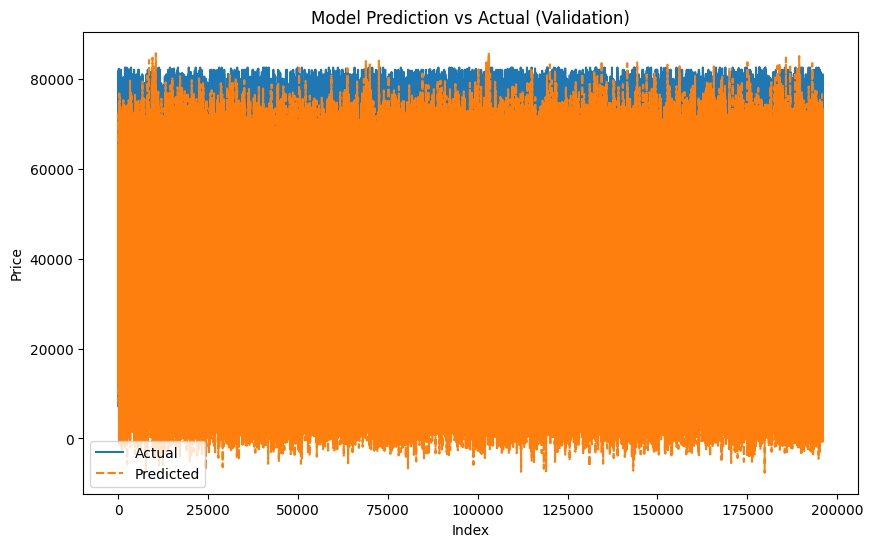

In [1]:
# 패키지/라이브러리 로드
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv("../../dataset/train.csv", encoding="utf-8")

# 데이터 타입 확인
print("=== 데이터 타입 확인 ===")
print(df.dtypes)

# 데이터 샘플링 (전체 데이터 사용)
# df_sampled = df.copy()  # 전체 데이터를 사용합니다.
# df_sampled = df.sample(frac=0.01, random_state=2024) # 1% 만 사용해서 빠르게 학습
df_sampled = df.sample(frac=1, random_state=2024)  # 100% 전부 사용

# 데이터 분석하기
print("\n=== df_sampled.info() ===")
df_sampled.info()

print("\n=== df_sampled.head() ===")
print(df_sampled.head())

# 1. transaction_year_month에서 '년', '월' 분리
if "transaction_year_month" in df_sampled.columns:
    df_sampled["transaction_year"] = df_sampled["transaction_year_month"] // 100
    df_sampled["transaction_month"] = df_sampled["transaction_year_month"] % 100

# 2. 필요없는 컬럼 제거
df_sampled = df_sampled.drop(
    [
        "transaction_id",  # 제거 (단순 식별자)
        "jibun",  # 제거 (너무 세부적인 위치 정보)
        "addr_kr",  # 제거 (중복 정보)
        "transaction_year_month",  # 이미 연도와 월로 분리함
        "transaction_date",  # 제거 (유의미하지 않음)
    ],
    axis=1,
    errors="ignore",
)

# 2-1. 결측치 처리
print("\n=== 결측치 확인 ===")
missing_values = df_sampled.isnull().sum()
print(missing_values)

# 결측치가 포함된 행을 제거하는 경우
df_sampled = df_sampled.dropna()

# 결측치를 평균 또는 중앙값으로 대체하는 경우
# df_sampled.fillna(df_sampled.mean(), inplace=True)


# 2-2. 이상치 처리 (사분위 범위(IQR)를 이용한 방법)

# 수치형 피처만 선택
numeric_columns = df_sampled.select_dtypes(include=[np.number]).columns

# 각 피처별 IQR을 기반으로 이상치 제거
for column in numeric_columns:
    Q1 = df_sampled[column].quantile(0.25)  # 1사분위
    Q3 = df_sampled[column].quantile(0.75)  # 3사분위
    IQR = Q3 - Q1  # IQR 계산
    lower_bound = Q1 - 1.5 * IQR  # 이상치 하한
    upper_bound = Q3 + 1.5 * IQR  # 이상치 상한

    # 이상치가 범위를 벗어난 값들을 제거
    df_sampled = df_sampled[
        (df_sampled[column] >= lower_bound)
        & (df_sampled[column] <= upper_bound)
    ]

print("\n=== 이상치 처리 완료 후 데이터프레임 정보 ===")
df_sampled.info()

# 3. 데이터 타입 변환 및 범주형 변수 처리

# 3-1. 'city' 컬럼 처리 (타깃 인코딩)
print("\n=== 'city' 컬럼의 고유값 수 ===")
print(df_sampled["city"].nunique())

# 'city' 컬럼에 대한 타깃 인코딩 적용
city_mean_price = df_sampled.groupby("city")["transaction_real_price"].mean()
df_sampled["city_encoded"] = df_sampled["city"].map(city_mean_price)
df_sampled = df_sampled.drop("city", axis=1)

# 3-2. 'dong' 컬럼 처리 (타깃 인코딩)
print("\n=== 'dong' 컬럼의 고유값 수 ===")
print(df_sampled["dong"].nunique())

# 'dong' 컬럼에 대한 타깃 인코딩 적용
dong_mean_price = df_sampled.groupby("dong")["transaction_real_price"].mean()
df_sampled["dong_encoded"] = df_sampled["dong"].map(dong_mean_price)
df_sampled = df_sampled.drop("dong", axis=1)

# 3-3. 'apt' 컬럼 처리 (타깃 인코딩)
print("\n=== 'apt' 컬럼의 고유값 수 ===")
print(df_sampled["apt"].nunique())

# 'apt' 컬럼에 대한 타깃 인코딩 적용
apt_mean_price = df_sampled.groupby("apt")["transaction_real_price"].mean()
df_sampled["apt_encoded"] = df_sampled["apt"].map(apt_mean_price)
df_sampled = df_sampled.drop("apt", axis=1)

# 3-4. 'apartment_id' 컬럼 처리 (타깃 인코딩)
print("\n=== 'apartment_id' 컬럼의 고유값 수 ===")
print(df_sampled["apartment_id"].nunique())

# 'apartment_id' 컬럼에 대한 타깃 인코딩 적용
apartment_id_mean_price = df_sampled.groupby("apartment_id")[
    "transaction_real_price"
].mean()
df_sampled["apartment_id_encoded"] = df_sampled["apartment_id"].map(
    apartment_id_mean_price
)
df_sampled = df_sampled.drop("apartment_id", axis=1)
# 4. 데이터 분리 (Feature와 Target 나누기)
X = df_sampled.drop("transaction_real_price", axis=1)
y = df_sampled["transaction_real_price"]

# 데이터 정보 출력
print("\n=== X.info() ===")
X.info()
print("\n=== X.head() ===")
print(X.head())
print("\n=== y.describe() ===")
print(y.describe())

# 5. 데이터 분할: train + validation(75%), test(25%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.25, random_state=2024
)

# 6. 데이터 분할: train(75%), validation(25%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=2024
)


# 7. 피처 스케일링 (StandardScaler 사용)
scaler = StandardScaler()

# 수치형 변수 선택 (스케일링 대상)
numeric_features = X_train.select_dtypes(include=[np.number]).columns
print("\n=== 스케일링 대상 수치형 피처 ===")
print(numeric_features)

# X_train, X_val, X_test 각각에 대해 스케일링 적용
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val[numeric_features] = scaler.transform(X_val[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# y 값은 스케일링하지 않음

# 8. 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 9. Validation 세트로 예측 및 RMSE 계산
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"\nValidation RMSE: {val_rmse:.2f}")

# 10. Test 세트로 예측 및 RMSE 계산
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE: {test_rmse:.2f}")

# 11. 모델 디버깅용 출력

# X_train, X_val 스케일링 후 값 확인
print("\n=== X_train 스케일링 후 값 (첫 5개) ===")
print(X_train.head())

print("\n=== X_val 스케일링 후 값 (첫 5개) ===")
print(X_val.head())

# y_val 실제 값 범위 확인
print("\n=== y_val 실제 값 범위 ===")
print(f"Min: {y_val.min()}, Max: {y_val.max()}")

# y_val_pred 예측 값 범위 확인
print("\n=== y_val_pred 예측 값 범위 ===")
print(f"Min: {y_val_pred.min()}, Max: {y_val_pred.max()}")

# 모델 회귀 계수 확인
print("\n=== 모델 회귀 계수 ===")
print(pd.Series(model.coef_, index=X_train.columns))


# 12. 시각화 함수 정의 및 적용
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=pd.DataFrame(
            {"Actual": y_true.reset_index(drop=True), "Predicted": y_pred}
        )
    )
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


# 13. 검증 세트 결과 시각화
plot_results(y_val, y_val_pred, "Model Prediction vs Actual (Validation)")

### 모델 회귀 계수와 해석

| 피처명                | 설명                                    | 예시 값 | 회귀 계수    | 해석                                                                                                                                     |
|-----------------------|-----------------------------------------|---------|--------------|------------------------------------------------------------------------------------------------------------------------------------------|
| **exclusive_use_area**      | 아파트의 전용면적 (제곱미터)            | 84.82   | 6,332.56     | 전용면적이 1㎡ 증가할 때마다 거래 가격이 약 **6,332.56**만큼 증가합니다. 이는 큰 집일수록 가격이 높아짐을 의미합니다.                          |
| **year_of_completion**      | 아파트 준공 연도                        | 2002    | -1,278.31    | 준공 연도가 1년 증가할 때마다 거래 가격이 약 **1,278.31**만큼 **감소**합니다. 즉, 더 새로운 아파트일수록 가격이 낮아지는 경향을 보입니다.        |
| **floor**                   | 아파트의 층수                           | 2       | 845.20       | 층수가 1층 증가할 때마다 거래 가격이 약 **845.20**만큼 증가합니다. 높은 층일수록 가격이 높아짐을 나타냅니다.                                    |
| **transaction_year**        | 거래 연도                               | 2008    | 2,932.60     | 거래 연도가 1년 증가할 때마다 거래 가격이 약 **2,932.60**만큼 증가합니다. 시간이 지남에 따라 부동산 가격이 상승하는 추세를 반영합니다.            |
| **transaction_month**       | 거래 월 (1~12월)                        | 1       | 463.80       | 거래 월이 1개월 증가할 때마다 거래 가격이 약 **463.80**만큼 증가합니다. 연도 내에서의 계절적 요인이나 월별 가격 변동을 나타냅니다.                |
| **city_서울특별시**         | 서울특별시 여부 (서울: 1, 그 외: 0)     | 1       | 3,337.47     | 아파트가 서울에 위치할 경우 거래 가격이 약 **3,337.47**만큼 더 높습니다. 서울의 부동산 가격이 다른 지역보다 높음을 반영합니다.                   |
| **apt_encoded**             | 아파트 단지의 평균 거래 가격 (타깃 인코딩)| 37,500  | -276.35      | 아파트 단지의 평균 거래 가격이 1만큼 증가할 때마다 거래 가격이 약 **276.35**만큼 **감소**합니다. 이는 예상과 반대이며, 상관관계나 다중공선성을 의심해볼 수 있습니다. |
| **apartment_id_encoded**    | 아파트 ID의 평균 거래 가격 (타깃 인코딩) | 7,622   | 25,094.90    | 아파트 ID의 평균 거래 가격이 1만큼 증가할 때마다 거래 가격이 약 **25,094.90**만큼 증가합니다. 이는 해당 아파트의 고유 가치가 거래 가격에 큰 영향을 미침을 의미합니다. |


# 추후 개선 제안
- **다중공선성 확인:**
  - **분산 팽창 계수(VIF)**를 사용하여 다중공선성을 확인하고, 높은 VIF 값을 가진 변수를 제거하거나 조정합니다.

- **모델 변경:**
  - 선형 회귀 모델 대신 **릿지(Ridge)** 또는 **라쏘(Lasso)** 회귀를 사용하여 과적합을 방지하고 모델의 일반화 성능을 향상시킬 수 있습니다.

- **데이터 검증:**
  - **교차 검증**을 통해 모델의 안정성과 성능을 검증합니다.

- **추가 데이터 수집:**
  - 더 많은 피처(예: 주변 시설, 교통 접근성 등)를 추가하여 모델의 설명력을 높일 수 있습니다.
  
- **피처 엔지니어링:**
  - **변수 변환:** 로그 변환이나 표준화를 통해 변수의 분포를 조정합니다.
  - **아파트 나이**를 계산하여 사용해보세요.
    - ```python
      df_sampled['apartment_age'] = df_sampled['transaction_year'] - df_sampled['year_of_completion']
      # 보류: 성능 지표는 거의 그대로인데, 모델 회귀 계수가 갑자기 이상해짐.
      #
      # === 모델 회귀 계수 ===
      # exclusive_use_area      6.333739e+03
      # year_of_completion     -1.004855e+14
      # floor                   8.451887e+02
      # transaction_year        3.264965e+13
      # transaction_month       4.637788e+02
      # city_서울특별시              3.337436e+03
      # apt_encoded            -2.763243e+02
      # apartment_id_encoded    2.509489e+04
      # apartment_age          -1.027334e+14
      ```